In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 270.2 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
import jax
import jax.numpy as jnp
import jaxopt
jax.config.update("jax_enable_x64", True)

import numpy as np

import tinygp
from tinygp import GaussianProcess, kernels
from tinygp.kernels import quasisep
print("tinygp version: " + tinygp.__version__)

#import eztao
#from eztao.carma import DRW_term
#from eztao.ts import gpSimRand
#print("eztao version: " + eztao.__version__)

import celerite
from celerite import terms
from celerite.modeling import Model
from celerite.solver import get_kernel_value

import scipy.optimize as sco
import jax.scipy as jsp
import jax.scipy.optimize as jsco

import numpy as np
import pickle
import cloudpickle

from tqdm import tqdm

import time

import matplotlib.pyplot as plt

tinygp version: 0.2.3


In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [4]:
"""
import os
# for benchmarking, no parallel
os.environ["JAX_ENABLE_X64"] = "True"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["XLA_FLAGS"] = (
    os.environ.get("XLA_FLAGS", "")
    + " --xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1"
)
"""

'\nimport os\n# for benchmarking, no parallel\nos.environ["JAX_ENABLE_X64"] = "True"\nos.environ["OMP_NUM_THREADS"] = "1"\nos.environ["XLA_FLAGS"] = (\n    os.environ.get("XLA_FLAGS", "")\n    + " --xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1"\n)\n'

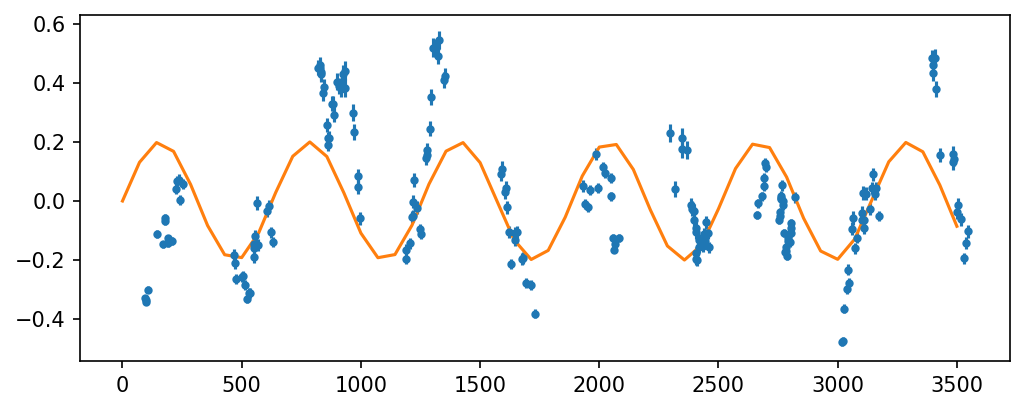

In [5]:
# Let us show how the fitting procedure works on a simple single example
# Define a DRW (damped random walk) kernel & and simulate a process
# by using the external package `EzTao`

#amp = 0.2
#tau = 100
#DRW_kernel = DRW_term(np.log(amp), np.log(tau))
#t, y_drw, yerr = gpSimRand(DRW_kernel, 10, 365*10, 200)

# This adds periodic component to the drw process
#y = y_drw + 0.2* np.sin(t/100)

t = np.load('/astro/users/ncaplar/data/t.npy')
y = np.load('/astro/users/ncaplar/data/y.npy')
yerr = np.load('/astro/users/ncaplar/data/yerr.npy')

# Now, plot it
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8,3))
#ax.errorbar(t, y_drw, yerr, fmt='.')
ax.errorbar(t, y, yerr, fmt='.')
ax.plot(np.linspace(0,3500), 0.2* np.sin(np.linspace(0,3500)/100) )

In [6]:
# TinyGP (JAX) code

# dictionary with some initial fitting values
theta_init = {
    "log_drw_scale": np.log10(100),
    "log_drw_amp": np.log10(0.25),
    "log_per_scale": np.log10(1.0),
    "log_per_amp": np.log10(4.3)
}

# array with some initial fitting values
theta_init_float = [np.log10(100), np.log10(0.25),np.log10(1.0), np.log10(4.3)]

def create_alt_theta_init(theta_init):
    """Create dictionary with random initial conditions
    """
    alt_theta_init = {
        "log_drw_scale": np.random.uniform(0,5),
        "log_drw_amp": np.random.uniform(-3,-0.25),
        "log_per_scale": np.random.uniform(0,5),
        "log_per_amp": np.random.uniform(-3,2)
}
    return alt_theta_init

def create_alt_theta_init_alt_float(n=None):
    """Create an array with random initial conditions
    """
    if n is None:
      n=1
    alt_theta_init = np.array([np.random.uniform(0,5,n), np.random.uniform(-3,-0.25,n),
                               np.random.uniform(0,5,n),np.random.uniform(-3,2,n)])

    return alt_theta_init

###############################
# 1. Build Gaussian proccesses
def build_gp(theta, t, y, yerr):
    """Build an Gaussian proccess that is a combination of exp and periodic
    """
    exp_kernel = quasisep.Exp(
        scale=10**theta["log_drw_scale"], sigma=10**theta["log_drw_amp"]
    )

    periodic_kernel = (
        quasisep.Cosine(
        scale=10**(theta["log_per_scale"]),
        sigma=10**(theta["log_per_amp"]),
        )
    )

    kernel = exp_kernel + periodic_kernel

    return GaussianProcess(kernel, t, diag=yerr, mean=np.mean(y))

def build_exp_gp(theta, t, y, yerr):
    """Build an Gaussian proccess that is only exp
    """
    exp_kernel = quasisep.Exp(
        scale=10**theta["log_drw_scale"], sigma=10**theta["log_drw_amp"]
    )

    return GaussianProcess(exp_kernel, t, diag=yerr, mean=np.mean(y))

def build_per_gp(theta, t, y, yerr):
    """Build an Gaussian proccess that is only periodic
    """
    periodic_kernel = (
        quasisep.Cosine(
        scale=10**(theta["log_per_scale"]),
        sigma=10**(theta["log_per_amp"]),
        )
    )

    return GaussianProcess(periodic_kernel, t, diag=yerr, mean=np.mean(y))

def build_gp_float(theta_float):
    """Build an Gaussian proccess that is a combination of exp and periodic
    Takes array as input, but no way to modify t,y,yerr
    """

    log_drw_scale = theta_float[0]
    log_drw_amp = theta_float[1]
    log_per_scale = theta_float[2]
    log_per_amp = theta_float[3]

    exp_kernel = quasisep.Exp(
        scale=10**log_drw_scale, sigma=10**log_drw_amp
    )

    periodic_kernel = (
        quasisep.Cosine(
        scale=10**(log_per_scale),
        sigma=10**(log_per_amp),
        )
    )

    kernel = exp_kernel + periodic_kernel

    return GaussianProcess(kernel, t, diag=yerr, mean=np.mean(y))

def build_gp_float(theta_float, t, y, yerr):
    """Build an Gaussian proccess that is a combination of exp and periodic
    Takes arrays as input
    """
    log_drw_scale = theta_float[0]
    log_drw_amp = theta_float[1]
    log_per_scale = theta_float[2]
    log_per_amp = theta_float[3]

    exp_kernel = quasisep.Exp(
        scale=10**log_drw_scale, sigma=10**log_drw_amp
    )

    periodic_kernel = (
        quasisep.Cosine(
        scale=10**(log_per_scale),
        sigma=10**(log_per_amp),
        )
    )

    kernel = exp_kernel + periodic_kernel

    return GaussianProcess(kernel, t, diag=yerr, mean=np.mean(y))
###############################

# 2. create loss function for each of gaussian processes
@jax.jit
def neg_log_likelihood(theta, t, y, yerr):
    gp = build_gp(theta, t, y, yerr)
    return -gp.log_probability(y)

@jax.jit
def neg_log_likelihood_per(theta, t, y, yerr):
    gp = build_per_gp(theta, t, y, yerr)
    return -gp.log_probability(y)

@jax.jit
def neg_log_likelihood_drw(theta, t, y, yerr):
    gp = build_exp_gp(theta, t, y, yerr)
    return -gp.log_probability(y)

@jax.jit
def neg_log_likelihood_float(theta_float):
    gp = build_gp_float(theta_float)
    return -gp.log_probability(y)

@jax.jit
def neg_log_likelihood_float(theta_float, t, y, yerr):
    gp = build_gp_float(theta_float, t, y, yerr)
    return -gp.log_probability(y)

# 3. test that you can evaluate in situ, both value and gradient
obj_dic = jax.jit(jax.value_and_grad(neg_log_likelihood))
obj_per = jax.jit(jax.value_and_grad(neg_log_likelihood_per))
obj_drw = jax.jit(jax.value_and_grad(neg_log_likelihood_drw))
# if on gpu, this will go via gpu
obj_float = jax.jit(jax.value_and_grad(neg_log_likelihood_float))
# always goes via cpu
obj_float_cpu = jax.jit(jax.value_and_grad(neg_log_likelihood_float), backend = 'cpu')

# 3.b print out values to verify
print(f"Initial negative log likelihood: {obj_dic(theta_init, t, y, yerr)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj_dic(theta_init, t, y, yerr)[1]}"
)
print("***************")

print(f"Initial negative log likelihood: {obj_per(theta_init, t, y, yerr)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj_per(theta_init, t, y, yerr)[1]}"
)
print("***************")

print(f"Initial negative log likelihood: {obj_drw(theta_init, t, y, yerr)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj_drw(theta_init, t, y, yerr)[1]}"
)
print("***************")

print(f"Initial negative log likelihood: {obj_float_cpu(theta_init_float, t, y, yerr)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj_float_cpu(theta_init_float, t, y, yerr)[1]}"
)
print("***************")

Initial negative log likelihood: -110.37569340223253
Gradient of the negative log likelihood, wrt the parameters:
{'log_drw_amp': Array(73.92130144, dtype=float64), 'log_drw_scale': Array(-30.70849313, dtype=float64), 'log_per_amp': Array(4.60510069, dtype=float64), 'log_per_scale': Array(-465.18646894, dtype=float64)}
***************
Initial negative log likelihood: 28.191255438347497
Gradient of the negative log likelihood, wrt the parameters:
{'log_drw_amp': Array(0., dtype=float64), 'log_drw_scale': Array(0., dtype=float64), 'log_per_amp': Array(4.604959, dtype=float64), 'log_per_scale': Array(69305.92116071, dtype=float64)}
***************
Initial negative log likelihood: -121.47895499025043
Gradient of the negative log likelihood, wrt the parameters:
{'log_drw_amp': Array(74.61071963, dtype=float64), 'log_drw_scale': Array(-31.07160244, dtype=float64), 'log_per_amp': Array(0., dtype=float64), 'log_per_scale': Array(0., dtype=float64)}
***************
Initial negative log likeliho

In [7]:
class CustomTerm_drw(terms.Term):
    parameter_names = ("log_drw_scale", "log_drw_amp")

    def get_real_coefficients(self, params):
        log_drw_scale, log_drw_amp = params
        #print('log_drw_scale: %f' % log_per_scale)
        # print('log_drw_amp: %f' % log_per_amp)
        # transform from tinygp convention to celerite convention
        drw_scale_cel =  (10**(-log_drw_scale))
        drw_amp_cel =(10**log_drw_amp)**2

        return (
            drw_amp_cel, drw_scale_cel
        )
        
class CustomTerm_per(terms.Term):
    parameter_names = ("log_per_scale", "log_per_amp")

    def get_complex_coefficients(self, params):
        log_per_scale, log_per_amp = params
        # print('log_per_scale: %f' % log_per_scale)
        # print('log_per_amp: %f' % log_per_amp)
        per_scale_cel = 2*np.pi/10**(log_per_scale)
        per_amp_cel = (10**log_per_amp)**2
        
        return (
            per_amp_cel, 0.0,
            0, per_scale_cel,
        )
        
        
class CustomTerm(terms.Term):
    parameter_names = ("log_drw_scale", "log_drw_amp", "log_per_scale", "log_per_amp")
    
    def get_real_coefficients(self, params):
        log_drw_scale, log_drw_amp, log_per_scale, log_per_amp = params
        #print('log_drw_scale: %f' % log_per_scale)
        # print('log_drw_amp: %f' % log_per_amp)
        # transform from tinygp convention to celerite convention
        drw_scale_cel =  (10**(-log_drw_scale))
        drw_amp_cel =(10**log_drw_amp)**2

        return (
            drw_amp_cel, drw_scale_cel
        )

    def get_complex_coefficients(self, params):
        log_drw_scale, log_drw_amp, log_per_scale, log_per_amp = params
        # print('log_per_scale: %f' % log_per_scale)
        # print('log_per_amp: %f' % log_per_amp)
        per_scale_cel = 2*np.pi/10**(log_per_scale)
        per_amp_cel = (10**log_per_amp)**2
        
        return (
            per_amp_cel, 0.0,
            0, per_scale_cel,
        )
        
test_init =  [2.5206846 ,   -0.77505314,    2.48349446, -1.23651853]
log_drw_scale = test_init[0]
log_drw_amp = test_init[1]
log_per_scale = test_init[2]
log_per_amp = test_init[3]
        
kernel_drw = CustomTerm_drw(log_drw_amp=log_drw_amp, log_drw_scale=log_drw_scale)
kernel_per = CustomTerm_per(log_per_amp=log_per_amp, log_per_scale=log_per_scale)
# kernel = kernel_drw + kernel_per
kernel = CustomTerm(log_drw_amp=log_drw_amp, log_drw_scale=log_drw_scale,
                    log_per_amp=log_per_amp, log_per_scale=log_per_scale)

gp_per_cel = celerite.GP(kernel_per, mean=np.mean(y))
gp_drw_cel = celerite.GP(kernel_drw, mean=np.mean(y))
gp = celerite.GP(kernel, mean=np.mean(y))


gp_per_cel.compute(t, yerr)  # You always need to call compute once.
gp_drw_cel.compute(t, yerr)  # You always need to call compute once.
gp.compute(t, yerr)  # You always need to call compute once.

print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
print("Initial log likelihood: {0}".format(gp_per_cel.log_likelihood(y)))
print("Initial log likelihood: {0}".format(gp_drw_cel.log_likelihood(y)))

print('gp_per_cel.kernel.terms' + str(gp_per_cel.kernel.terms[0].coefficients))
print('gp_per_cel.get_parameter_vector' + str(gp_per_cel.get_parameter_vector()))
print('##################')

print('gp_drw_cel.kernel.terms' + str(gp_drw_cel.kernel.terms[0].coefficients))
print('gp_drw_cel.get_parameter_vector' + str(gp_drw_cel.get_parameter_vector()))
print('##################')

print('gp.kernel.terms' + str(gp.kernel.terms[0].coefficients))
print('gp.get_parameter_vector' + str(gp.get_parameter_vector()))
print(kernel.get_parameter_dict())
print('##################')

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
initial_params = gp.get_parameter_vector()
#omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))
#psd = gp.kernel.get_psd(omega)

Initial log likelihood: 187.25236451846112
Initial log likelihood: -11614.67503747428
Initial log likelihood: 186.51497791272115
gp_per_cel.kernel.terms[array([], dtype=float64), array([], dtype=float64), array([0.00336483]), array([0.]), array([0]), array([0.02063885])]
gp_per_cel.get_parameter_vector[ 2.48349446 -1.23651853]
##################
gp_drw_cel.kernel.terms[array([0.02817693]), array([0.00301519]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
gp_drw_cel.get_parameter_vector[ 2.5206846  -0.77505314]
##################
gp.kernel.terms[array([0.02817693]), array([0.00301519]), array([0.00336483]), array([0.]), array([0]), array([0.02063885])]
gp.get_parameter_vector[ 2.5206846  -0.77505314  2.48349446 -1.23651853]
OrderedDict([('log_drw_scale', 2.5206846), ('log_drw_amp', -0.77505314), ('log_per_scale', 2.48349446), ('log_per_amp', -1.23651853)])
##################


In [8]:
# Run all the minimizations avaliable once

# default backend (gpu), native scipy optimization
%time soln = sco.minimize(obj_float, x0=theta_init_float, jac=True, method="bfgs", args=(t, y, yerr))
# default backend (gpu), jax scipy optimization
%time jsoln = jsco.minimize(neg_log_likelihood_float, x0=jnp.array(theta_init_float), method="bfgs", args=(jnp.array(t), jnp.array(y), jnp.array(yerr)))
# celerite (cpu)
# can this be made even faster with gradient provided
%time soln_celerite = sco.minimize(neg_log_like, x0 = initial_params, method="bfgs", args=(y, gp))

CPU times: user 3.64 s, sys: 8.53 s, total: 12.2 s
Wall time: 3.02 s
CPU times: user 13 s, sys: 29.9 s, total: 43 s
Wall time: 13.5 s
CPU times: user 27.7 ms, sys: 0 ns, total: 27.7 ms
Wall time: 27.7 ms


In [9]:
def jsoln_jax_ty(t,y,yerr):
    # via jax implementation of scipy minimize
    # remove jnp.array, i.e., demand that inputs are jax arrays?
    jsoln = jsco.minimize(neg_log_likelihood_float, x0=jnp.array(theta_init_float), method="bfgs", args=(jnp.array(t), jnp.array(y), jnp.array(yerr)))
    return jsoln.fun

def soln_jax_ty(t,y,yerr):
    # via original scipy minimize, via gpu
    # remove jnp.array, i.e., demand that inputs are jax arrays?
    soln = sco.minimize(obj_float, x0=jnp.array(theta_init_float),jac=True, method="bfgs",
                         args=(jnp.array(t), jnp.array(y), jnp.array(yerr)))
    return soln.fun

def soln_jax_ty_cpu(t,y,yerr):
    # via original scipy minimize, via cpu
    # remove jnp.array, i.e., demand that inputs are jax arrays?
    soln = sco.minimize(obj_float_cpu, x0=jnp.array(theta_init_float),jac=True, method="bfgs",
                         args=(jnp.array(t), jnp.array(y), jnp.array(yerr)))
    return soln.fun

def soln_cel_ty(t,y,yerr):
    # remove jnp.array, i.e., demand that inputs are jax arrays?
    soln_celerite = sco.minimize(neg_log_like, x0 = initial_params, method="bfgs", args=(y, gp))
    return soln_celerite.fun

In [10]:
%time jsoln_jax_ty(t,y,yerr);
%time soln_jax_ty(t,y,yerr);
%time soln_jax_ty_cpu(t,y,yerr);
%time soln_cel_ty(t,y,yerr);

CPU times: user 8.74 s, sys: 3.66 s, total: 12.4 s
Wall time: 5.5 s
CPU times: user 563 ms, sys: 6.55 ms, total: 569 ms
Wall time: 564 ms
CPU times: user 576 ms, sys: 13.1 ms, total: 589 ms
Wall time: 553 ms
CPU times: user 18.9 ms, sys: 0 ns, total: 18.9 ms
Wall time: 18.6 ms


In [11]:
# putting the data on gpu device seems very fast
%time t_jax = jax.device_put(t)
%time y_jax = jax.device_put(y)
%time yerr_jax = jax.device_put(yerr)

CPU times: user 203 µs, sys: 475 µs, total: 678 µs
Wall time: 474 µs
CPU times: user 76 µs, sys: 144 µs, total: 220 µs
Wall time: 126 µs
CPU times: user 30 µs, sys: 57 µs, total: 87 µs
Wall time: 87.3 µs


In [12]:
jsoln_jax_ty_cpu = jax.jit(jsoln_jax_ty, backend="cpu")
jsoln_jax_ty_gpu = jax.jit(jsoln_jax_ty, backend="gpu")
# can not be jitted, because they are using native scipy
# soln_jax_ty_cpu = jax.jit(soln_jax_ty, backend="cpu")
# soln_jax_ty_gpu = jax.jit(soln_jax_ty, backend="gpu")

%time jsoln_jax_ty_cpu(t_jax, y_jax, yerr_jax) # measure JAX compilation time
%time jsoln_jax_ty_gpu(t_jax, y_jax, yerr_jax)

%timeit jsoln_jax_ty_cpu(t_jax, y_jax, yerr_jax) # measure JAX runtime
%timeit jsoln_jax_ty_gpu(t_jax, y_jax, yerr_jax)

CPU times: user 3 s, sys: 34.7 ms, total: 3.04 s
Wall time: 2.86 s
CPU times: user 11.3 s, sys: 26.2 s, total: 37.5 s
Wall time: 8.13 s
5.74 ms ± 22 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.47 s ± 4.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# this defines the function that does vmap
jsoln_jax_ty_cpu_vmap = jax.vmap(jsoln_jax_ty_cpu, in_axes=(0, 0, 0))
jsoln_jax_ty_gpu_vmap = jax.vmap(jsoln_jax_ty_gpu, in_axes=(0, 0, 0))
#soln_jax_ty_vmap = jax.vmap(soln_jax_ty, in_axes=(0, 0, 0))
#soln_jax_ty_cpu_vmap = jax.vmap(soln_jax_ty_cpu, in_axes=(0, 0, 0))

In [14]:
# generate fake data
# how many lightcurves to create
n_lc = 10

# Define the range for random variations
variation_range = 0.1  # Adjust this value to control the extent of variation
t_batch = []
y_batch = []
yerr_batch = []

# Create variations
for _ in range(n_lc):  # Change the number as per your requirement
    t_var = [time + np.random.uniform(-variation_range, variation_range) for time in t]
    y_var = [data + np.random.uniform(-variation_range, variation_range) for data in y]
    yerr_var = [err + np.random.uniform(-variation_range, variation_range) for err in y]
    t_batch.append(t_var)
    y_batch.append(y_var)
    yerr_batch.append(yerr_var)

t_batch = np.array(t_batch)
y_batch = np.array(y_batch)
yerr_batch = np.array(yerr_batch)

In [15]:
# single test, how to vmap jax scipy function
%time results = jsoln_jax_ty_cpu_vmap(t_batch, y_batch, yerr_batch)
%time results = jsoln_jax_ty_gpu_vmap(t_batch, y_batch, yerr_batch)

CPU times: user 5.05 s, sys: 63.8 ms, total: 5.12 s
Wall time: 4.93 s
CPU times: user 12.7 s, sys: 27.9 s, total: 40.6 s
Wall time: 8.94 s


In [28]:
# ns = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
ns = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000])
cpu_time_jsol = []
gpu_time_jsol = []
cpu_time_jsol_vmap = []
gpu_time_jsol_vmap = []
gpu_time_sol = []
cel_time_sol = []
cpu_time_sol = []
for n_lc in ns:
  print(f"\nN = {n_lc}:")

  # Define the range for random variations|
  variation_range = 0.01  # Adjust this value to control the extent of variation

  t_batch = []
  y_batch = []
  yerr_batch = []

  # Create variations
  variation_range = 0.0000001
  for _ in range(n_lc):  # Change the number as per your requirement
      t_var = t
      y_var =y
      yerr_var = yerr
      t_batch.append(t_var)
      y_batch.append(y_var)
      yerr_batch.append(yerr_var)

  t_batch = np.array(t_batch)
  y_batch = np.array(y_batch)
  yerr_batch = np.array(yerr_batch)

  t_batch_jax = jnp.array(t_batch)
  y_batch_jax = jnp.array(y_batch)
  yerr_batch_jax = jnp.array(yerr_batch)

  
  if n_lc<1001:
    results = %timeit -o jsoln_jax_ty_cpu_vmap(t_batch_jax, y_batch_jax, yerr_batch_jax).block_until_ready()
    cpu_time_jsol_vmap.append(results.average)


  if n_lc<5001:
    results = %timeit -o result = map(jsoln_jax_ty_cpu, t_batch, y_batch, yerr_batch); list(result);
    cpu_time_jsol.append(results.average)



  if n_lc<501:
    results = %timeit -o result = map(soln_jax_ty_cpu, t_batch, y_batch, yerr_batch); list(result);
    cpu_time_sol.append(results.average)
  
  if n_lc<501:
    results = %timeit -o result = map(soln_cel_ty, t_batch, y_batch, yerr_batch); list(result);
    cel_time_sol.append(results.average)
    
  if n_lc<5001:
    results = %timeit -o jsoln_jax_ty_gpu_vmap(t_batch_jax, y_batch_jax, yerr_batch_jax).block_until_ready()
    gpu_time_jsol_vmap.append(results.average)
  
  if n_lc<6:
    results = %timeit -o result = map(soln_jax_ty, t_batch, y_batch, yerr_batch); list(result);
    gpu_time_sol.append(results.average)
    
  if n_lc<11:
    results = %timeit -o result = map(jsoln_jax_ty_gpu, t_batch, y_batch, yerr_batch); list(result);
    gpu_time_jsol.append(results.average)    



N = 1:


6.37 ms ± 17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.65 ms ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.3 ms ± 52.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.5 ms ± 19.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.48 s ± 932 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
555 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.48 s ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

N = 2:
11.6 ms ± 37.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.3 ms ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
22.3 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
34.2 ms ± 66.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.5 s ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.1 s ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.94 s ± 4.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

N = 5:
26.2 ms 

2023-07-23 20:50:43.510920: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_jsoln_jax_ty] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-07-23 20:52:45.600010: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m2.086959895s

********************************
[Compiling module jit_jsoln_jax_ty] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


11.3 s ± 93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

N = 5000:
28.4 s ± 231 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


2023-07-23 21:32:00.530827: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 25m38.329092938s

********************************
[Compiling module jit_jsoln_jax_ty] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


25.2 s ± 81.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


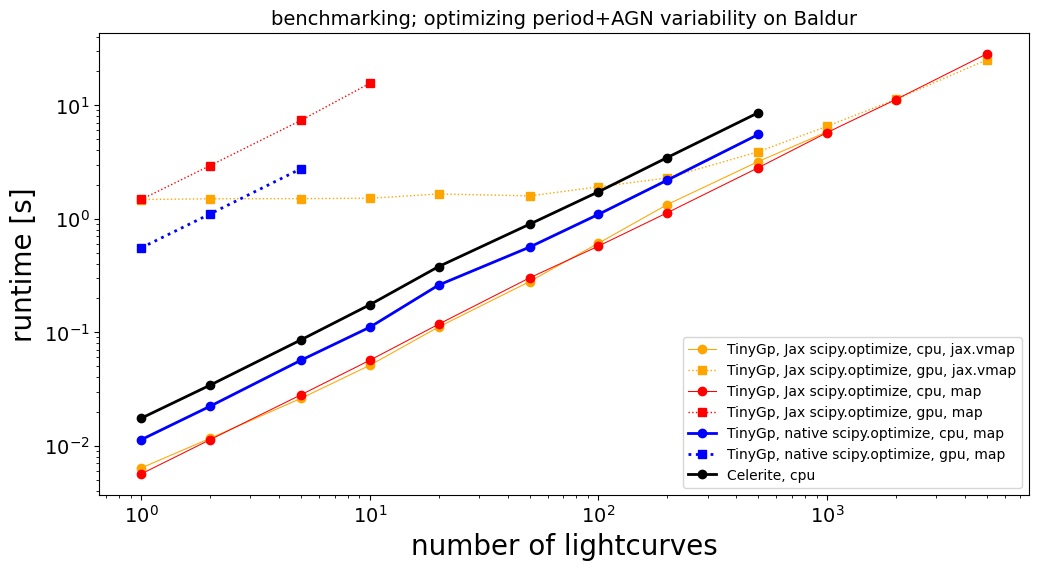

In [30]:
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  

# ns = np.array([1, 2, 5, 10, 20, 50, 100, 200])
plt.figure(figsize=(12,6))
plt.title('benchmarking; optimizing period+AGN variability on Baldur'
)

plt.loglog(
    np.array(ns)[:len(cpu_time_jsol_vmap)],
    cpu_time_jsol_vmap,
    "o-",
    color="orange",
    lw=0.75,
    label="TinyGp, Jax scipy.optimize, cpu, jax.vmap",
)
plt.loglog(
    np.array(ns)[:len(gpu_time_jsol_vmap)],
    gpu_time_jsol_vmap,
    "s:",
    color="orange",
    lw=1,
    label="TinyGp, Jax scipy.optimize, gpu, jax.vmap",
)



plt.loglog(
    np.array(ns)[:len(cpu_time_jsol)],
    cpu_time_jsol,
    "o-",
    color="red",
    lw=0.75,
    label="TinyGp, Jax scipy.optimize, cpu, map",
)
plt.loglog(
    np.array(ns)[:len(gpu_time_jsol)],
    gpu_time_jsol,
    "s:",
    color="red",
    lw=1,
    label="TinyGp, Jax scipy.optimize, gpu, map",
)




plt.loglog(
    np.array(ns)[:len(cpu_time_sol)],
    cpu_time_sol,
    "o-",
    color="blue",
    lw=2,
    label="TinyGp, native scipy.optimize, cpu, map",
)

plt.loglog(
    np.array(ns)[:len(gpu_time_sol)],
    gpu_time_sol,
    "s:",
    color="blue",
    lw=2,
    label="TinyGp, native scipy.optimize, gpu, map",
)

plt.loglog(
    np.array(ns)[:len(cel_time_sol)],
    cel_time_sol,
    "o-",
    color="black",
    lw=2,
    label="Celerite, cpu",
)

plt.legend(fontsize=10)
plt.xlabel("number of lightcurves")
plt.ylabel("runtime [s]");

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

